# 1). Install Dependencies and Setup

In [ ]:
!pip install tensorflow tensorflow-gpu opencv-python matplotlib
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout,BatchNormalization
import tensorflow as tf
import os
import cv2
import imghdr
import numpy as np
from matplotlib import pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout,BatchNormalization

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#from keras.applications.vgg16 import preprocess_input
# Tensorflow Libraries
from tensorflow import keras
from tensorflow.keras import layers,models
from keras_preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Input, Activation, add, Add, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.callbacks import Callback, EarlyStopping,ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Model
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

# System libraries
from pathlib import Path
import os.path

# Metrics
from sklearn.metrics import classification_report, confusion_matrix
import itertools

In [ ]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [ ]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
#https://www.kaggle.com/code/vencerlanz09/bird-classification-using-cnn-mobilenetv2
#Create helper functions
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

# Import series of helper functions for our notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir, pred_and_plot

--2022-10-19 10:42:33--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.5’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-10-19 10:42:33 (111 MB/s) - ‘helper_functions.py.5’ saved [10246/10246]



# 2). Map google Drive


In [ ]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)
!cp -r 'drive/MyDrive/BuddhastatueData' '/content/data'
#data_dir = '/drive/Othercomputers/KaiAIPC/KanisPC/nida/7202 deep learning/HW2/BuddhastatueData' 

train_dir='data/train/'
validate_dir='data/validate/'
test_dir='data/test/'


Mounted at /content/drive/


In [ ]:
import random
import numpy as np
import tensorflow as tf
#seed=1111
seed=2222
#seed=3333
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

# 3). Load Data

In [ ]:
img_w=256
img_h=256
num_classes = 8
my_batch_size=32


train_datagen_aug = ImageDataGenerator(
    preprocessing_function=preprocess_input)

validate_datagen_aug = ImageDataGenerator(
   preprocessing_function=preprocess_input)


train_generator_aug = train_datagen_aug.flow_from_directory(
    train_dir,
    target_size=(img_w, img_h),
    batch_size=my_batch_size,
    class_mode='categorical')

valid_generator_aug = validate_datagen_aug.flow_from_directory(
    validate_dir,
    target_size=(img_w, img_h),
    batch_size=my_batch_size,
    class_mode='categorical')



Found 1112 images belonging to 8 classes.
Found 368 images belonging to 8 classes.


In [ ]:
# Walk through each directory
walk_through_dir(train_dir);

There are 8 directories and 0 images in 'data/train/'.
There are 0 directories and 124 images in 'data/train/5thu'.
There are 0 directories and 112 images in 'data/train/2tue'.
There are 0 directories and 111 images in 'data/train/3wedm'.
There are 0 directories and 111 images in 'data/train/4wedn'.
There are 0 directories and 201 images in 'data/train/6fri'.
There are 0 directories and 114 images in 'data/train/1mon'.
There are 0 directories and 156 images in 'data/train/7sat'.
There are 0 directories and 183 images in 'data/train/8sun'.


# 4). Placing Data into a Dataframe



In [ ]:
import pandas as pd
image_dir = Path(train_dir)

# Get filepaths and labels
filepaths = list(image_dir.glob(r'**/*.JPG')) + list(image_dir.glob(r'**/*.jpg')) + list(image_dir.glob(r'**/*.png')) + list(image_dir.glob(r'**/*.png'))

labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# Concatenate filepaths and labels
image_df = pd.concat([filepaths, labels], axis=1)

#5). Visualizing images from the dataset

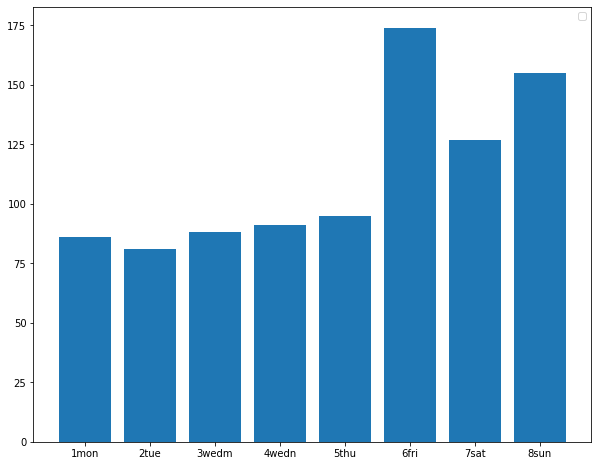

In [ ]:
import seaborn as sns
plt.figure(figsize=(10,8))
class_cnt = image_df.groupby(['Label']).size().reset_index(name = 'counts')
#colors = sns.color_palette('Paired')[0:9]
plt.bar(height=class_cnt['counts'], x=class_cnt['Label'])
plt.legend(loc='upper right')
plt.show()

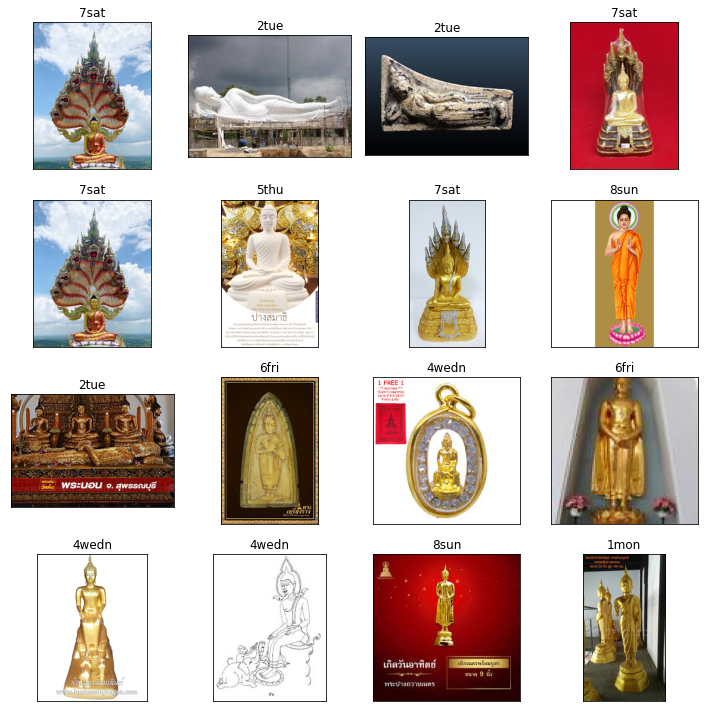

In [ ]:
# Display 16 picture of the dataset with their labels
random_index = np.random.randint(0, len(image_df), 16)
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepath[random_index[i]]))
    ax.set_title(image_df.Label[random_index[i]])
plt.tight_layout()
plt.show()

# 6). Build Deep Learning Model: MobileNetV2

#6.1). Backbone: First we will create the base MobileNetV2 model

In [ ]:
# load the MobileNetV2 architecture with imagenet weights as base
mbn_basemodel = tf.keras.applications.MobileNetV2(
                     include_top=False,
                     weights='imagenet',
                     input_shape=(img_w,img_h,3)
                     )
 
mbn_basemodel.trainable=False
# For freezing the layer we make use of layer.trainable = False
# means that its internal state will not change during training.
# model's trainable weights will not be updated during fit(),
# and also its state updates will not run.

mbn_basemodel.summary()


Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 128, 128, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 128, 128, 32  128         ['Conv1[0][0]']                  
                                )                                              

#6.2). Data Augmentation and Model Compilation

In [ ]:
data_augmentation = Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.Normalization(),
        #layers.RandomFlip("horizontal"),
        #layers.RandomRotation(factor=0.1),
        #layers.RandomContrast(factor=0.1),
        #layers.RandomZoom(height_factor=0.2, width_factor=0.2),
    ]
)

model = tf.keras.Sequential([
        data_augmentation,
        mbn_basemodel,  
        tf.keras.layers.GlobalAveragePooling2D(),
        #tf.keras.layers.Dense(512, activation='relu'),
        #tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(8, activation='softmax')
    ])

model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])
# categorical cross entropy is taken since its used as a loss function for
# multi-class classification problems where there are two or more output labels.
# using Adam optimizer for better performance
# other optimizers such as sgd can also be used depending upon the model

model.build((None,img_w,img_h,3))
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 256, 256, 3)       7         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 8, 8, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_1   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_2 (Dense)             (None, 256)               327936    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 8)                

In [ ]:
'''validation_steps=20
initial_epochs = 20

loss0,accuracy0 = model.evaluate(valid_generator_aug, steps = validation_steps)'''

'validation_steps=20\ninitial_epochs = 20\n\nloss0,accuracy0 = model.evaluate(valid_generator_aug, steps = validation_steps)'

In [ ]:
logdir='logsMBNV22'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

#7). Training Data

#7.1). Pre-train Model Training

In [ ]:
import time
## Pre Training

start_time = time.time()
hist = model.fit(train_generator_aug,
                    validation_data=valid_generator_aug,
                    epochs=20,
                    callbacks=[tensorboard_callback])

end_time = time.time()
print('####################################')
print('#  Training time = %s seconds ---' % (end_time - start_time))

Epoch 1/20
35/35 [==============================] - 24s 548ms/step - loss: 1.7812 - accuracy: 0.3507 - val_loss: 1.2905 - val_accuracy: 0.5543
Epoch 2/20
35/35 [==============================] - 16s 456ms/step - loss: 1.1522 - accuracy: 0.5791 - val_loss: 1.1967 - val_accuracy: 0.5380
Epoch 3/20
35/35 [==============================] - 17s 465ms/step - loss: 0.9606 - accuracy: 0.6628 - val_loss: 1.0635 - val_accuracy: 0.6168
Epoch 4/20
35/35 [==============================] - 16s 453ms/step - loss: 0.8225 - accuracy: 0.7095 - val_loss: 1.0170 - val_accuracy: 0.6440
Epoch 5/20
35/35 [==============================] - 16s 448ms/step - loss: 0.7221 - accuracy: 0.7482 - val_loss: 1.1061 - val_accuracy: 0.6114
Epoch 6/20
35/35 [==============================] - 16s 454ms/step - loss: 0.6636 - accuracy: 0.7482 - val_loss: 1.0155 - val_accuracy: 0.6549
Epoch 7/20
35/35 [==============================] - 17s 489ms/step - loss: 0.5862 - accuracy: 0.7986 - val_loss: 1.0013 - val_accuracy: 0.6495

#7.2). Pre-train Performance

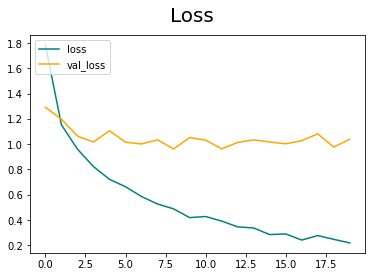

In [ ]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

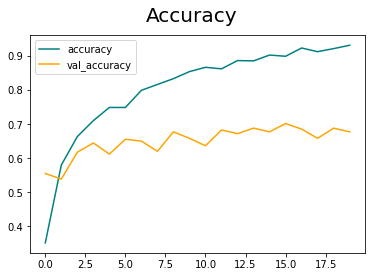

In [ ]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

#7.3). Evaluate Test Data

In [ ]:
# evaluate model

test_datagen_aug = ImageDataGenerator(
   preprocessing_function=preprocess_input)

test_it = test_datagen_aug.flow_from_directory(test_dir, target_size=(img_w, img_h),
    batch_size=my_batch_size,
    class_mode='categorical')


start_time = time.time()

score = model.evaluate(test_it)

end_time = time.time()

print("Loss: ", score[0], "Accuracy: ", score[1])
print('####################################')
print('#  Inference time = %s seconds ---' % (end_time - start_time))

Found 372 images belonging to 8 classes.
12/12 [==============================] - 6s 495ms/step - loss: 1.0853 - accuracy: 0.6613
Loss:  1.085288643836975 Accuracy:  0.6612903475761414
####################################
#  Inference time = 6.170054912567139 seconds ---


#8). Fine Tuning Model

In [ ]:
mbn_basemodel.trainable = True

# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(mbn_basemodel.layers))

# Fine-tune from this layer onwards
fine_tune_at = 20

# Freeze all the layers before the `fine_tune_at` layer
for layer in mbn_basemodel.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  154


In [ ]:
for layer in mbn_basemodel.layers:
    if "BatchNormalization" in layer.__class__.__name__:
        layer.trainable = True

We can then recompile and start training the model:

In [ ]:
model.compile(optimizer=Adam(0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# fit model
start_time = time.time()
new_history = model.fit(train_generator_aug,
                         epochs=20,
                         validation_data=valid_generator_aug,
                         callbacks=[tensorboard_callback]
                         )
end_time = time.time()
print('####################################')
print('#  Training time = %s seconds ---' % (end_time - start_time))


Epoch 1/20
35/35 [==============================] - 22s 478ms/step - loss: 0.7762 - accuracy: 0.7437 - val_loss: 1.1832 - val_accuracy: 0.6712
Epoch 2/20
35/35 [==============================] - 16s 450ms/step - loss: 0.4116 - accuracy: 0.8543 - val_loss: 1.1607 - val_accuracy: 0.6957
Epoch 3/20
35/35 [==============================] - 16s 461ms/step - loss: 0.2666 - accuracy: 0.9065 - val_loss: 1.0945 - val_accuracy: 0.7255
Epoch 4/20
35/35 [==============================] - 17s 472ms/step - loss: 0.1986 - accuracy: 0.9344 - val_loss: 1.1719 - val_accuracy: 0.7174
Epoch 5/20
35/35 [==============================] - 16s 463ms/step - loss: 0.1986 - accuracy: 0.9353 - val_loss: 1.0844 - val_accuracy: 0.7391
Epoch 6/20
35/35 [==============================] - 18s 508ms/step - loss: 0.1452 - accuracy: 0.9550 - val_loss: 1.0940 - val_accuracy: 0.7527
Epoch 7/20
35/35 [==============================] - 16s 474ms/step - loss: 0.1292 - accuracy: 0.9577 - val_loss: 1.1436 - val_accuracy: 0.7582

# 8.1). Tuned Model Performance

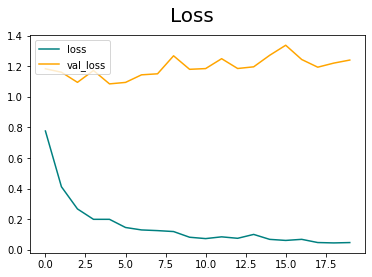

In [ ]:
fig = plt.figure()
plt.plot(new_history.history['loss'], color='teal', label='loss')
plt.plot(new_history.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

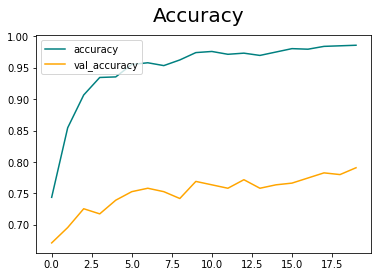

In [ ]:
fig = plt.figure()
plt.plot(new_history.history['accuracy'], color='teal', label='accuracy')
plt.plot(new_history.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

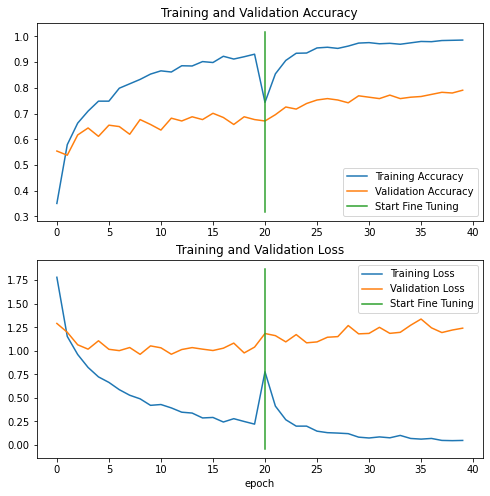

In [ ]:
compare_historys(original_history=hist, new_history=new_history,initial_epochs=21)

#8.3). Tuned Model Evaluation on Test Data


In [ ]:
# evaluate model

test_datagen_aug = ImageDataGenerator(
   preprocessing_function=preprocess_input)

test_it = test_datagen_aug.flow_from_directory(test_dir, target_size=(img_w, img_h),
    batch_size=my_batch_size,
    class_mode='categorical')


start_time = time.time()

score = model.evaluate(test_it)

end_time = time.time()

print("Loss: ", score[0], "Accuracy: ", score[1])
print('####################################')
print('#  Inference time = %s seconds ---' % (end_time - start_time))




Found 372 images belonging to 8 classes.
12/12 [==============================] - 6s 514ms/step - loss: 1.0510 - accuracy: 0.7823
Loss:  1.051009178161621 Accuracy:  0.7822580933570862
####################################
#  Inference time = 6.689687490463257 seconds ---


# 9). Save the Model

In [ ]:
from tensorflow.keras.models import load_model

In [ ]:
model.save(os.path.join('models','BuddhastatueDataimageclassifiermbnv2.h5'))

In [ ]:
'''new_model = load_model('models/BuddhastatueDataimageclassifiermbnv2.h5')'''

"new_model = load_model('models/BuddhastatueDataimageclassifiermbnv2.h5')"

In [ ]:
!nvidia-smi

Wed Oct 19 10:54:16 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   64C    P0    40W / 250W |   4739MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

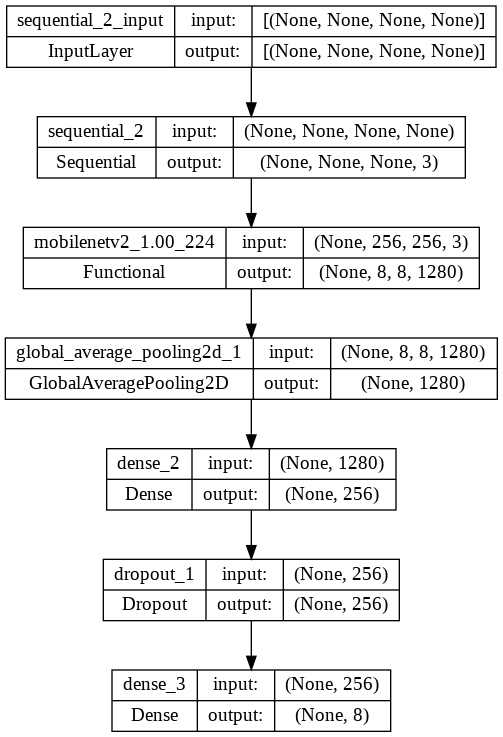

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.utils.vis_utils import plot_model

plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)